## Не завершено, в течение часа
Практическое задание:
- взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)
- сделать обзорный анализ выбранного датасета
- сделать feature engineering
- обучить любой классификатор (какой вам нравится)
- разобраться с SHAP и построить важности признаков для:
    - всего тестового набора данных (summary_plot - дать интерпретацию)
    - для топ 10%
- для отдельных наблюдений вывести force_plot и попытаться проинтерпретировать результат

In [1]:
import pandas as pd
import numpy as np

import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

from xgboost import XGBClassifier
import shap

# load JS visualization code to notebook
shap.initjs()


Тот же набор, что и в HW6.

https://archive.ics.uci.edu/ml/datasets/Bank+Marketing

## Bank Marketing Data Set

Abstract: The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe a term deposit (variable y).

bank-full.csv with all examples and 17 inputs, ordered by date (older version of this dataset with less inputs).

### Информация о признаках:

#### Данные о клиенте:
1. age : возраст (числовой)
2. job : тип работы (категориальный: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3. marital : семейное положение (категориальный: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4. education (категориальный: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5. default: был ли дефолт по кредиту? (categorical: 'no','yes','unknown')
6. housing: есть ли ипотека? (categorical: 'no','yes','unknown')
7. loan: есть ли личные кредиты? (categorical: 'no','yes','unknown')

#### последний контакт текущей кампании:
8. contact: тип связи (categorical: 'cellular','telephone')
9. month: последний контакт - месяц (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10. day: последний контакт - день
11. duration: длительность последнего контакта (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

#### другие атрибуты:
12. campaign: число контактов в течение этой кампании (числовой, включая последний контакт)
13. pdays: число дней после последнего контакта предыдущей кампании (numeric; 999 means client was not previously contacted)
14. previous: число контактов перед текущей кампанией  (numeric)
15. poutcome: результат предыдущей кампании (categorical: 'failure','nonexistent','success')


Целевая переменная :
21 - y - был ли клиент подписан на срочный вклад? (binary: 'yes','no')



In [2]:


df = pd.read_csv("bank/bank-full.csv", sep=';')
display(df)
display(df.describe())
display(df.dtypes)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object
dtype: object

In [3]:
# https://github.com/marrrcin/pandas-feature-union/blob/master/pandas_feature_union.py
# Хотелось попробовать использовать механизм pipeline, но FeatureUnion теряет информацию о колонках. 
# Нашлось такое решение

from sklearn.pipeline import FeatureUnion, _fit_transform_one, _transform_one
from scipy import sparse

class PandasFeatureUnion(FeatureUnion):
    def fit_transform(self, X, y=None, **fit_params):
        self._validate_transformers()
        result = [_fit_transform_one(
                        transformer=trans,
                        X=X,
                        y=y,
                        weight=weight, **fit_params) for name, trans, weight in self._iter()]

        if not result:
            # All transformers are None
            return np.zeros((X.shape[0], 0))
        Xs, transformers = zip(*result)
        self._update_transformer_list(transformers)
        if any(sparse.issparse(f) for f in Xs):
            Xs = sparse.hstack(Xs).tocsr()
        else:
            Xs = self.merge_dataframes_by_column(Xs)
        return Xs

    def merge_dataframes_by_column(self, Xs):
        return pd.concat(Xs, axis="columns", copy=False)

    def transform(self, X):
        Xs = [_transform_one(
                transformer=trans,
                X=X,
                y=None,
                weight=weight)
            for name, trans, weight in self._iter()]
        if not Xs or len(list(Xs)) == 0:
            return np.zeros((X.shape[0], 0))
        if any(sparse.issparse(f) for f in Xs):
            Xs = sparse.hstack(Xs).tocsr()
        else:
            Xs = self.merge_dataframes_by_column(Xs)
        return Xs

In [4]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]

    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

def yes_no_to_boolean(df, f):
    df.loc[df[f]=='yes', f] = 1
    df.loc[df[f]=='no', f] = 0
    df[f] = df[f].astype(int).fillna(0)
    
def build_pipeline(classifier, num_transformers=None):
    final_transformers = list()

    for col in cat_features:
        transformer = Pipeline([
                    ('selector', FeatureSelector(column=col)),
                    ('ohe', OHEEncoder(key=col))
                ])
        final_transformers.append((col, transformer))

    for col in num_features:
        transformer = Pipeline([('selector', NumberSelector(key=col))] +
        ([(get_name(ct), ct) for ct in num_transformers] if num_transformers is not None else []))
        final_transformers.append((col, transformer))

    feats = PandasFeatureUnion(final_transformers)
    pipeline = Pipeline([
        ('features',feats),
        ('classifier', classifier),
    ])
    return pipeline

def run(name, pipeline, **fit_params):
    pipeline.fit(X_train, y_train, **fit_params)
    preds = pipeline.predict_proba(X_test)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_test, preds)

    fscore = (2 * precision * recall) / (precision + recall)
    ix = np.argmax(fscore)
    
    cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
    
    TN = cnf_matrix[0][0]
    FN = cnf_matrix[1][0]
    TP = cnf_matrix[1][1]
    FP = cnf_matrix[0][1]
    
    business_metric = 0 # TODO
    
    metrics = (thresholds[ix], fscore[ix], precision[ix], recall[ix], business_metric, cnf_matrix, preds)
    metrics_string = 'Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % metrics[0:4]
    results[name] = (metrics_string,) + metrics
    return pipeline




In [5]:
fdf = df.iloc[:,0:-1]
tdf = df.iloc[:,-1:]
features = fdf.columns.tolist()
target = tdf.columns.tolist()[0]
num_features = fdf.select_dtypes(include=np.number).columns.tolist()
cat_features = fdf.select_dtypes(exclude=np.number).columns.tolist()

yes_no_to_boolean(tdf, 'y')

X_train, X_test, y_train, y_test = train_test_split(fdf, tdf[target], random_state=0)

print("Признаки: ", features)
print("Целевая переменная: ", target)
print("Числовые признаки: ", num_features)
print("Категориальные признаки: ", cat_features)



Признаки:  ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome']
Целевая переменная:  y
Числовые признаки:  ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
Категориальные признаки:  ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']


In [6]:
results = {}
pipeline = run("XGBClassifier", build_pipeline(XGBClassifier(random_state=0)))
pipeline

Pipeline(memory=None,
         steps=[('features',
                 PandasFeatureUnion(n_jobs=None,
                                    transformer_list=[('job',
                                                       Pipeline(memory=None,
                                                                steps=[('selector',
                                                                        FeatureSelector(column='job')),
                                                                       ('ohe',
                                                                        OHEEncoder(key='job'))],
                                                                verbose=False)),
                                                      ('marital',
                                                       Pipeline(memory=None,
                                                                steps=[('selector',
                                                                        FeatureSelector(c

In [7]:
for k, v in results.items():
    print(v[0])

Best Threshold=0.242996, F-Score=0.603, Precision=0.510, Recall=0.740


In [8]:
X_train_transformed = pipeline[0].transform(X_train)
X_test_transformed = pipeline[0].transform(X_test)

In [9]:
explainer = shap.TreeExplainer(pipeline[1])


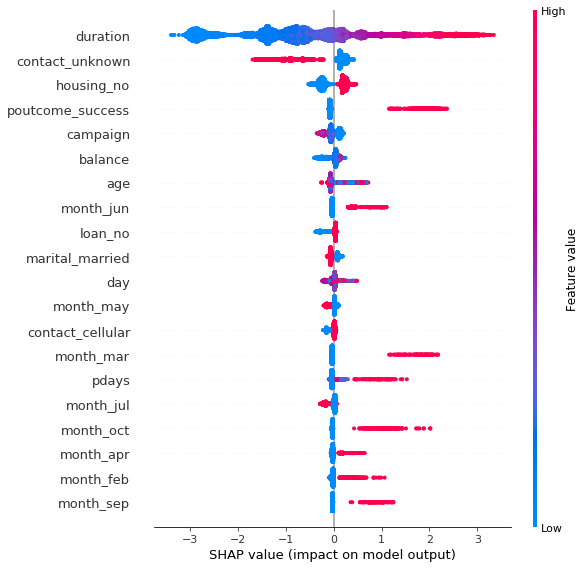

In [10]:
# для всех тестовых данных
shap_values = explainer.shap_values(X_test_transformed)
shap.summary_plot(shap_values, X_test_transformed)

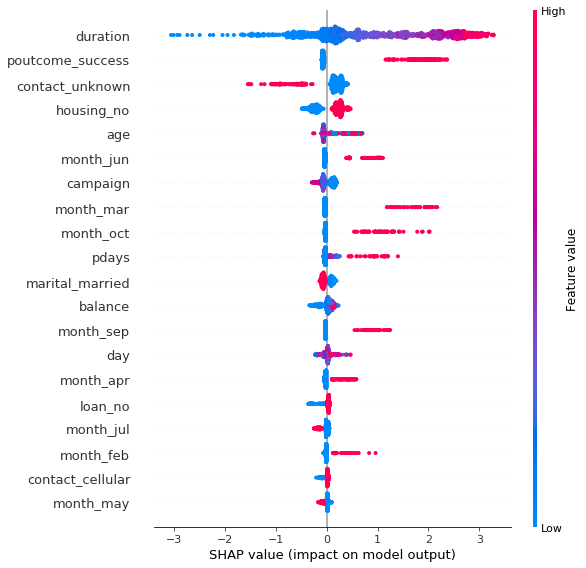

In [11]:
# для 10% top
X_test_transformed_top10p = pd.concat((X_test_transformed, y_test.rename('y')), axis=1).sort_values(by='y', ascending=False)[0:int(len(X_test_transformed)*0.1)].iloc[:,0:-1]
shap_values_top10p = explainer.shap_values(X_test_transformed_top10p)
shap.summary_plot(shap_values_top10p, X_test_transformed_top10p)


In [18]:

shap.force_plot(explainer.expected_value, shap_values[0,:], X_test_transformed.iloc[0,:])

In [17]:
shap.force_plot(explainer.expected_value, shap_values_top10p[0,:], X_test_transformed_top10p.iloc[0,:])